Tutorial 5: Ray Tracing
=======================

In the previous tutorial, we used planes to perform strong lens calculations. The use of planes was a bit cumbersome:
we had to set up each galaxy, pass them to each plane and manually use each plane to perform every ray-tracing
calculation ourselves. It was easy to make a mistake!

However, remember how the `Galaxy` objects contains its `redshift` as an attribute? Given a list of galaxies, there
should be no need for us to manually specify each plane setup and manually perform each ray-tracing calculations
ourself. All of the information required to do this is contained in the galaxies!

In this tutorial, we introduce potentially the most important object in **PyAutoLens**, the `Tracer`. This exploits the
redshift information of galaxies to automatically perform ray-tracing calculations.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

Let use the same grid we've grown love by now!

In [2]:
image_plane_grid = al.Grid2D.uniform(shape_native=(100, 100), pixel_scales=0.05)

For our lens galaxy, we'll use the same spherical isothermal mass profile again.

In [3]:
sis_mass_profile = al.mp.SphIsothermal(centre=(0.0, 0.0), einstein_radius=1.6)

lens_galaxy = al.Galaxy(redshift=0.5, mass=sis_mass_profile)

print(lens_galaxy)

Redshift: 0.5
Mass Profiles:
SphIsothermal
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
angle: 0.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0


And for the source, the same spherical Sersic light profile.

In [4]:
sersic_light_profile = al.lp.SphSersic(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0
)

source_galaxy = al.Galaxy(redshift=1.0, light=sersic_light_profile)

print(source_galaxy)

Redshift: 1.0
Light Profiles:
SphSersic
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
angle: 0.0
intensity: 1.0
effective_radius: 1.0
sersic_index: 1.0


__Tracers__

Now, lets use the lens and source galaxies to ray-trace the grid, however this time using a `Tracer` object.  
When we pass our galaxies into the `Tracer` below, the following happens:

1) The galaxies are ordered in ascending redshift.
2) Planes are created at every one of these redshifts, with each galaxy associated with the plane at its redshift.

In [5]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

The has the list of planes as an attribute, which in this example is two planes (an image and source plane).

In [6]:
print(tracer.planes)

[<autogalaxy.plane.plane.Plane object at 0x7fe579c0fa60>, <autogalaxy.plane.plane.Plane object at 0x7fe579c0fc70>]


We can access these using the `image_plane` and `source_plane` attributes.

In [7]:
print("Image Plane:")
print(tracer.planes[0])
print(tracer.image_plane)
print()
print("Source Plane:")
print(tracer.planes[1])
print(tracer.source_plane)

Image Plane:

Source Plane:


__Ray Tracing__

With a `Tracer` we create fully ray-traced images without manually setting up the planes and performing lensing 
calculations one-by-one to do this. The function below does the following:

 1) Using the lens's total mass distribution, the deflection angle of every image-plane $(y,x)$ grid coordinate is 
 computed.
 2) These deflection angles are used to trace every image-plane coordinate to the source-plane.
 3) The light of each traced source-plane coordinate is evaluated using the source plane galaxy's light profiles.

In [8]:
traced_image = tracer.image_2d_from_grid(grid=image_plane_grid)
print("traced image pixel 1")
print(traced_image.native[0, 0])
print("traced image pixel 2")
print(traced_image.native[0, 1])
print("traced image pixel 3")
print(traced_image.native[0, 2])

traced image pixel 1
0.220722395935053
traced image pixel 2
0.23414557508809547
traced image pixel 3
0.24823165669160918


This image appears as the Einstein ring we saw in the previous tutorial.

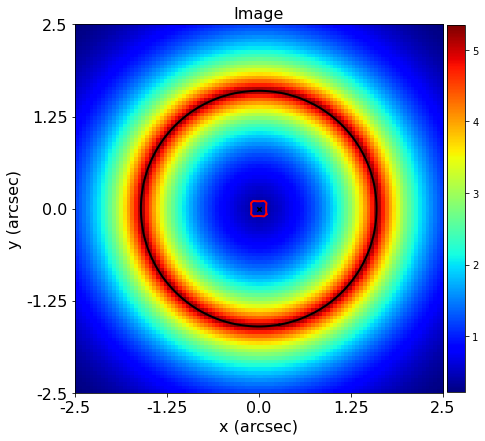

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)
tracer_plotter.figures_2d(image=True)

We can also use the tracer to compute the traced grid of every plane:

In [10]:
traced_grids = tracer.traced_grids_of_planes_from_grid(grid=image_plane_grid)

The first traced grid corresponds to the image-plane grid (i.e. before lensing), whereas the second grid is that of
the source-plane.

In [11]:
print("grid image-plane (y,x) coordinate 1")
print(traced_grids[0].native[0, 0])
print("grid image-plane (y,x) coordinate 2")
print(traced_grids[0].native[0, 1])
print("grid source-plane (y,x) coordinate 1")
print(traced_grids[1].native[0, 0])
print("grid source-plane (y,x) coordinate 2")
print(traced_grids[1].native[0, 1])

grid image-plane (y,x) coordinate 1
[ 2.475 -2.475]
grid image-plane (y,x) coordinate 2
[ 2.475 -2.425]
grid source-plane (y,x) coordinate 1
[ 1.34362915 -1.34362915]
grid source-plane (y,x) coordinate 2
[ 1.33214405 -1.30523205]


We can use the `TracerPlotter` to plot these planes and grids.

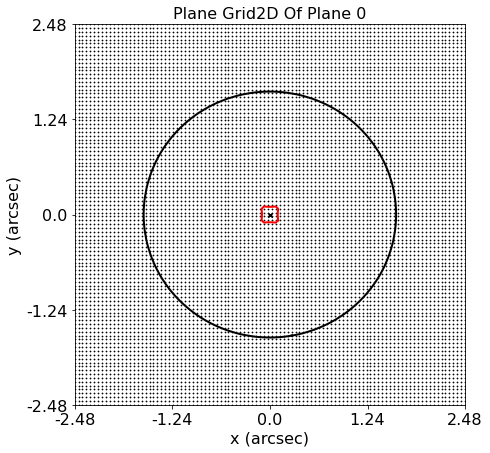

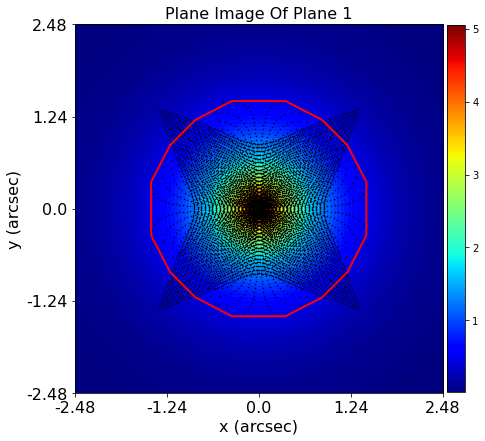

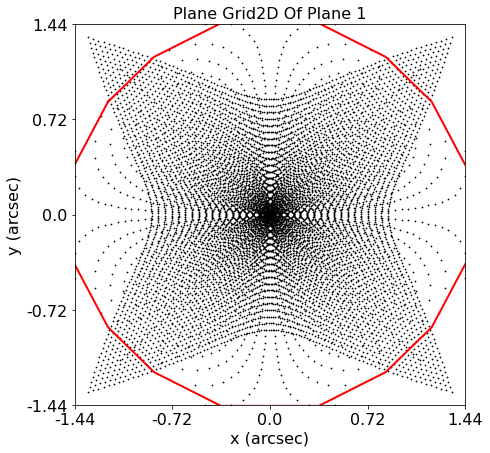

In [12]:
include_2d = aplt.Include2D(grid=True)

tracer_plotter = aplt.TracerPlotter(
    tracer=tracer, grid=image_plane_grid, include_2d=include_2d
)
tracer_plotter.figures_2d_of_planes(plane_image=True, plane_grid=True, plane_index=0)
tracer_plotter.figures_2d_of_planes(plane_image=True, plane_grid=True, plane_index=1)

A ray-tracing subplot plots the following:

 1) The image, computed by ray-tracing the source-galaxy's light from the source-plane to the image-plane.
 2) The source-plane image, showing the source-galaxy's intrinsic appearance (i.e. if it were not lensed).
 3) The image-plane convergence, computed using the lens galaxy's total mass distribution.
 4) The image-plane gravitational potential, computed using the lens galaxy's total mass distribution.
 5) The image-plane deflection angles, computed using the lens galaxy's total mass distribution.

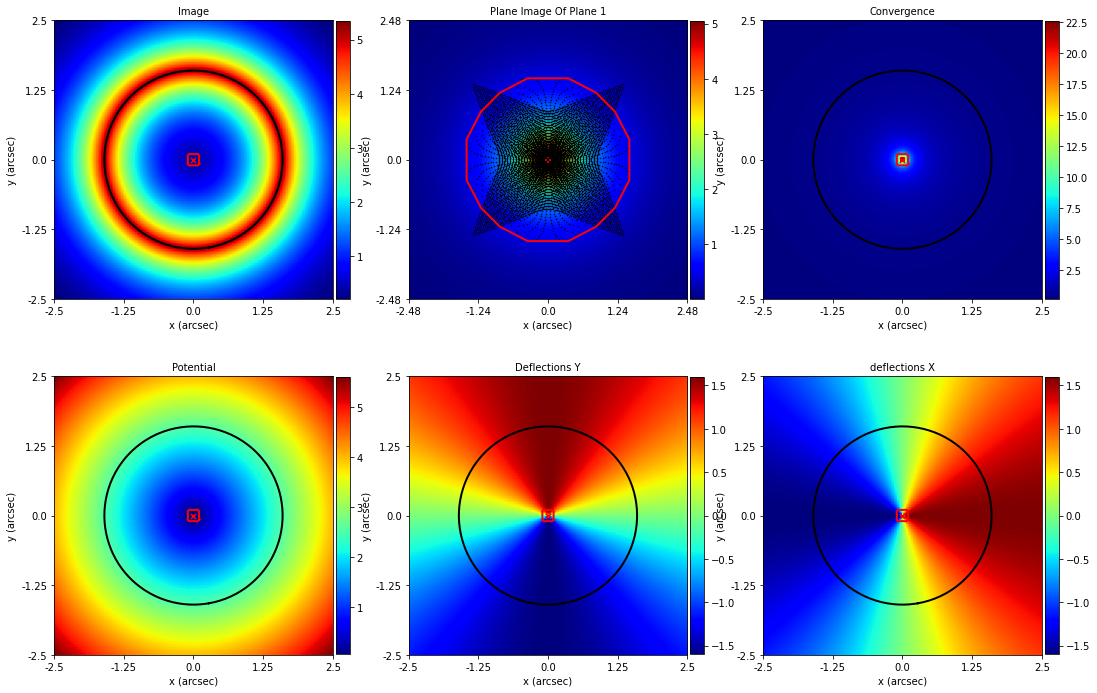

In [13]:
tracer_plotter.subplot_tracer()

Just like for a profile, galaxy or plane, these quantities attributes can be computed via a `_from_grid` method.

In [14]:
convergence = tracer.convergence_2d_from_grid(grid=image_plane_grid)

print("Tracer convergence at coordinate 1:")
print(convergence.native[0, 0])
print("Tracer convergence at coordinate 2:")
print(convergence.native[0, 1])
print("Tracer convergence at coordinate 101:")
print(convergence.native[1, 0])

Tracer convergence at coordinate 1:
0.22855976765625777
Tracer convergence at coordinate 2:
0.23087999050506058
Tracer convergence at coordinate 101:
0.23087999050506058


Of course, these convergences are identical to the image-plane convergences, as it`s only the lens galaxy that 
contributes to the overall mass of the ray-tracing system.

In [15]:
image_plane_convergence = tracer.image_plane.convergence_2d_from_grid(
    grid=image_plane_grid
)

print("Image-Plane convergence at coordinate 1:")
print(image_plane_convergence.native[0, 0])
print("Image-Plane convergence at coordinate 2:")
print(image_plane_convergence.native[0, 1])
print("Image-Plane convergene at coordinate 101:")
print(image_plane_convergence.native[1, 0])

Image-Plane convergence at coordinate 1:
0.22855976765625777
Image-Plane convergence at coordinate 2:
0.23087999050506058
Image-Plane convergene at coordinate 101:
0.23087999050506058


I've left the rest below commented to avoid too many print statements, but if you're feeling adventurous go ahead 
and uncomment the lines below!

In [16]:
# print("Potential:")
# print(tracer.potential_2d_from_grid(grid=image_plane_grid))
# print(tracer.image_plane.potential_2d_from_grid(grid=image_plane_grid))
# print("Deflections:")
# print(tracer.deflections_2d_from_grid(grid=image_plane_grid))
# print(tracer.image_plane.deflections_2d_from_grid(grid=image_plane_grid))

The `TracerPlotter` can also plot the above attributes as individual figures:

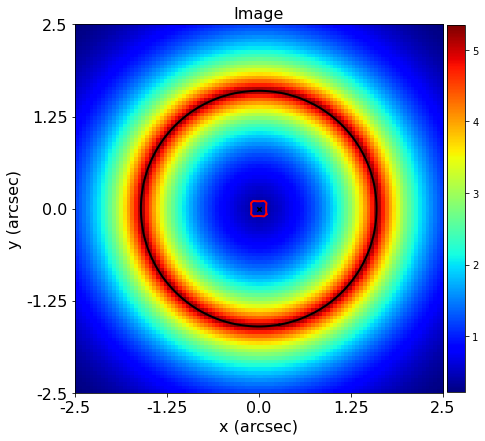

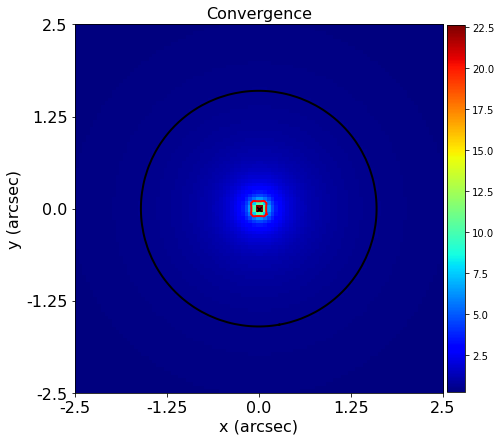

In [17]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)
tracer_plotter.figures_2d(
    image=True,
    convergence=True,
    potential=False,
    deflections_y=False,
    deflections_x=False,
)

__Caustics__

In the previous tutorial, we plotted the critical curves of the mass profile on the image-plane. We will now plot the
'caustics', which correspond to each critical curve ray-traced to the source-plane. This is computed by using the 
lens galaxy mass profile's to calculate the deflection angles at the critical curves and ray-trace them to the 
source-plane.

As discussed in the previous tutorial, critical curves mark regions of infinite magnification. Thus, if a source
appears near a caustic in the source plane it will appear significantly brighter than its true luminosity. 

We can plot both the critical curve and caustic using an `Include2D` object. Note how the critical curve appears
only for the image-plane grid, whereas the caustic only appears in the source plane.

NOTE: Again, numerical issues make the caustic appear 'jagged' when it should be smooth.

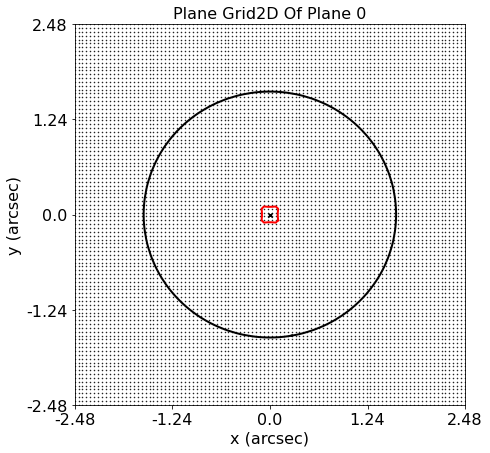

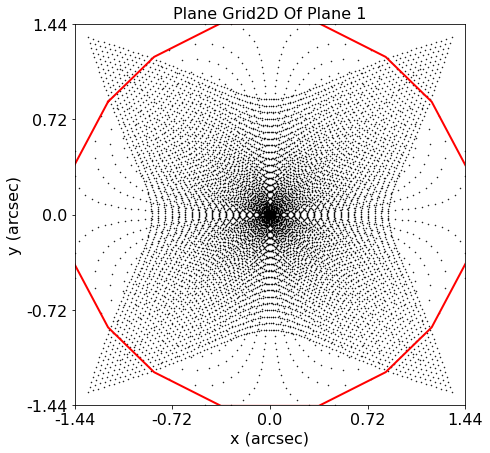

In [18]:
include_2d = aplt.Include2D(critical_curves=True, caustics=True)
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)

tracer_plotter.figures_2d_of_planes(plane_grid=True, plane_index=0)
tracer_plotter.figures_2d_of_planes(plane_grid=True, plane_index=1)

We can also plot the caustic on the source-plane image.

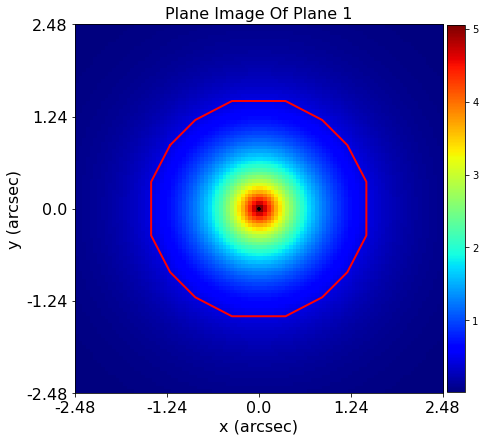

In [19]:
tracer_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

Caustics also mark the regions in the source-plane where the multiplicity of the strong lens changes. That is,
if a source crosses a caustic, it goes from 2 images to 1 image. Try and show this yourself by changing the (y,x) 
centre of the source-plane galaxy's light profile!

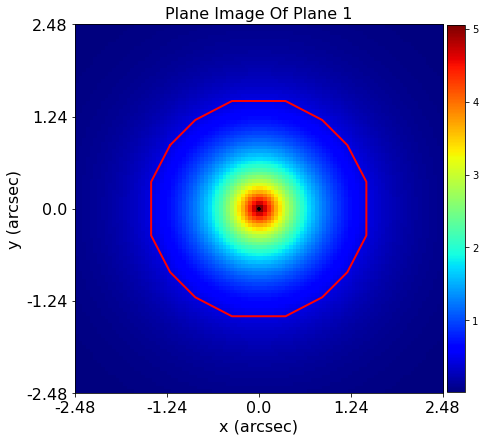

In [20]:
sersic_light_profile = al.lp.SphSersic(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0
)
source_galaxy = al.Galaxy(redshift=1.0, light=sersic_light_profile)
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=image_plane_grid)
tracer_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

__Wrap Up__

You might be wondering why do both the tracer and its image-plane have the attributes convergence / potential / 
deflection angles, when the two are identical? Afterall, only mass profiles contribute to these quantities, and 
only image-plane galaxies have had mass profiles so far!

The reason is due 'multi-plane' lensing, which is basically any lensing configuration where there are more than 2 
galaxies at more than 2 redshifts. For example, we could have a lensing system with 3 galaxies, at redshifts 0.5, 1.0 
and 2.0 (you can make such a system in the `Tracer` if you wish!).
 
When there are more than 2 planes, the convergence, potential and deflections at each individual plane is different to 
that of the entire multi-plane strong lens system. This is beyond the scope of this chapter, but be reassured that 
what you're learning now will prepare you for the advanced chapters later on!

And with that, we're done. You`ve performed your first ray-tracing with **PyAutoLens**! There are no exercises for this 
chapter, and we're going to take a deeper look at ray-tracing in the next chapter.